In [2]:
from VBNN_class import VBNN
from helper import ELBO_Mix, ELBO_Simple, ELBO_Choice
from helper import empirical_coverage, nll, get_data
from scipy.stats import invgamma as invgamma, uniform as uniform, norm as gaussian
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from copy import deepcopy
import networkx as nx
%matplotlib inline


### Define simulated data

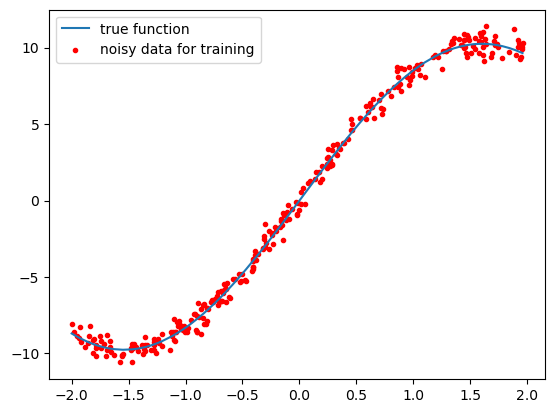

In [3]:
def some_function(x): 
    return 10*np.sin(x[:,0]) + 0.1*x[:,0]**2

rng = np.random.default_rng(seed=36)

N = 300
D_x = 2

x_simulated = np.array([uniform.rvs(-2, 4, N, random_state = rng) for _ in range(D_x)]).T
noise = gaussian.rvs(0, 0.5, (N,1), random_state = rng)
y_simulated_noise = (some_function(x_simulated).reshape(N,1) + noise)
y_simulated_true = (some_function(x_simulated)).reshape(N,1)

idx = np.argsort(x_simulated[:,0])

plt.plot(x_simulated[:,0][idx], y_simulated_true[idx],  label = 'true function')
plt.scatter(x_simulated[:, 0], y_simulated_noise, marker ='.',  color = 'red', label = 'noisy data for training')

plt.legend()

### Split and scale data

In [4]:
X_t, X_p, Y_t, Y_p = get_data(x_simulated, y_simulated_noise, 647, 0.1)

### Parameters to give to the 'ELBO_choice' or 'ELBO_Simple'
If using 'ELBO_Mix', then delete "wb_mode" entry.  

In [5]:
parameters_choice = {
"x"        : X_t,
"y"     :  Y_t,
"D_a"   : 20, 
"L"     :  1,
"T"     : 0.1,
"wb_mode"  : 'laplace', 
"big_S" : 0.01
}


#### Example of using 'ELBO_Simple'

In [ ]:
m = ELBO_Simple(parameters_choice)
m.model_choice(x_new = X_p, runs =10, epochs = 100, epochs_pred=40, rate = 1e-5, rate_pred=1e-5)


done epochs:  100
elbo:  -10978.225217056599
done pred  5
elbo pred:  [[-1023.21012316]]


In [ ]:
prediction = m.prediction
prediction_std = m.prediction_std


print('The metrics are:')
print('R2 score:', r2_score(Y_p, prediction))
print('NLL:', nll(Y_p, prediction, prediction_std))
print('Coverage:', empirical_coverage(Y_p, prediction, prediction_std))

The metrics are:
R2 score: 0.9939609295192756
NLL: 0.909649
Coverage: 1.0


#### Plot predictions

Text(0.5, 0, '$x_1$')

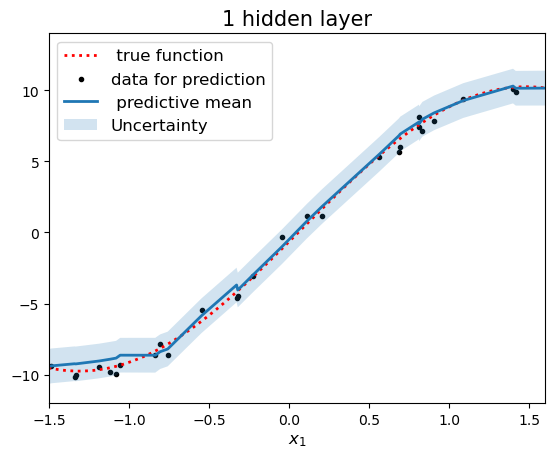

In [15]:

scaler = preprocessing.StandardScaler().fit(x_simulated)
X_scaled = scaler.transform(x_simulated)
idx = np.argsort(X_scaled[:,0])

plt.figure()
# plt.figure(dpi = 300)
plt.plot(X_scaled[:,0][idx], y_simulated_true[idx], linestyle = ':', linewidth = 2, color = 'red', label = ' true function')

plt.scatter(X_p[:, 0], Y_p, marker = '.', color = 'black', label = 'data for prediction')
xidx = (X_p[:, 0].reshape(-1)).argsort()
plt.plot(X_p[:, 0].reshape(-1)[xidx], prediction.reshape(Y_p.shape)[:, 0].reshape(-1)[xidx], linewidth = 2, label= ' predictive mean')
plt.fill_between(X_p[:, 0].reshape(-1)[xidx], prediction.reshape(Y_p.shape)[:, 0].reshape(-1)[xidx] - 2*prediction_std.reshape(-1)[xidx], prediction.reshape(Y_p.shape)[:, 0].reshape(-1)[xidx] + 2* prediction_std.reshape(-1)[xidx], alpha = 0.2, label = 'Uncertainty')



plt.xlim(-1.5, 1.6)
plt.ylim(-12, 14)
plt.title(str(m.L) + ' hidden layer', fontsize = 15)
plt.legend(loc = 'upper left', fontsize = 12)
plt.xlabel(r'$x_1$', fontsize = 12)

#### Example of using 'ELBO_Choice'in order to access the model, its weights and sparse predictions

In [16]:

m = ELBO_Choice(parameters_choice)
model = m.model_choice(runs = 1,  epochs=140, rate = 1e-6, dm = True)

In [18]:

prediction = model.predict(X_p, 40, 1e-5)
prediction_std = np.sqrt(model.var_tot)

In [19]:


alpha = 1e-3
epsilon = 0.1
y_model_sparse = model.sparse_predict(x_for_pred=X_p, epochs_pred = 30, alpha =alpha, epsilon = 0.1)
var_tot_sparse = np.copy(model.var_tot)

----
0.9999999965798827 0.9999999965798827 0.0
0.9999999965798827 0.9999998550325455 8.55029325119716e-11
0.9999998550325455 0.9999996471836207 3.619209067941242e-09
0.9999996471836207 0.9999979826092449 1.19334274076156e-08
0.9999979826092449 0.9998836866938753 5.857196991245606e-08
0.9998836866938753 0.9998350485527533 2.7007250188852567e-06
0.9998350485527533 0.9995536239811144 6.3062966239479936e-06
0.9995536239811144 0.9970171417788559 1.5873029716593503e-05
0.9970171417788559 0.9898702578192538 7.900037421505067e-05
0.9898702578192538 0.9794792117802419 0.00028839082851778397
0.9794792117802419 0.9760827304825841 0.0007012968977267702
done, kappa upon which we threshold is  0.9760827304825841


#### Plot predictions/sparse predictions

Text(0.5, 0, '$x_1$')

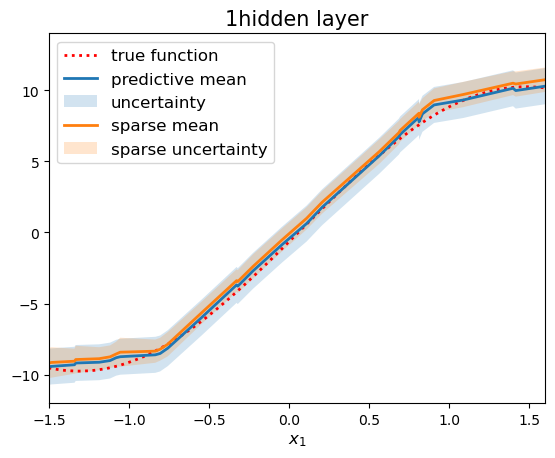

In [21]:

scaler = preprocessing.StandardScaler().fit(x_simulated)
X_scaled = scaler.transform(x_simulated)
idx = np.argsort(X_scaled[:,0])

plt.figure()
# plt.figure(dpi = 300)
plt.plot(X_scaled[:,0][idx], y_simulated_true[idx], linestyle = ':', linewidth = 2, color = 'red', label = 'true function')

xidx = (X_p[:, 0].reshape(-1)).argsort()
plt.plot(X_p[:, 0].reshape(-1)[xidx], prediction.reshape(Y_p.shape)[:, 0].reshape(-1)[xidx], linewidth = 2, label= 'predictive mean')
plt.fill_between(X_p[:, 0].reshape(-1)[xidx], prediction.reshape(Y_p.shape)[:, 0].reshape(-1)[xidx] - 2*prediction_std.reshape(-1)[xidx], prediction.reshape(Y_p.shape)[:, 0].reshape(-1)[xidx] + 2* prediction_std.reshape(-1)[xidx], alpha = 0.2, label = 'uncertainty')


plt.plot(X_p[:, 0].reshape(-1)[xidx], y_model_sparse.reshape(Y_p.shape)[:, 0].reshape(-1)[xidx], linewidth = 2, label= 'sparse mean')
plt.fill_between(X_p[:, 0].reshape(-1)[xidx], y_model_sparse.reshape(Y_p.shape)[:, 0].reshape(-1)[xidx] - 2*var_tot_sparse.reshape(-1)[xidx], y_model_sparse.reshape(Y_p.shape)[:, 0].reshape(-1)[xidx] + 2* var_tot_sparse.reshape(-1)[xidx], alpha = 0.2, label = 'sparse uncertainty')



plt.xlim(-1.5, 1.6)
plt.ylim(-12, 14)
plt.title(str(model.L) + 'hidden layer', fontsize = 15)
plt.legend(loc = 'upper left', fontsize = 12)
plt.xlabel(r'$x_1$', fontsize = 12)

----
0.9999999965798827 0.9999999965798827 0.0
0.9999999965798827 0.9999998550325455 8.55029325119716e-11
0.9999998550325455 0.9999996471836207 3.619209067941242e-09
0.9999996471836207 0.9999979826092449 1.19334274076156e-08
0.9999979826092449 0.9998836866938753 5.857196991245606e-08
0.9998836866938753 0.9998350485527533 2.7007250188852567e-06
0.9998350485527533 0.9995536239811144 6.3062966239479936e-06
done, kappa upon which we threshold is  0.9995536239811144


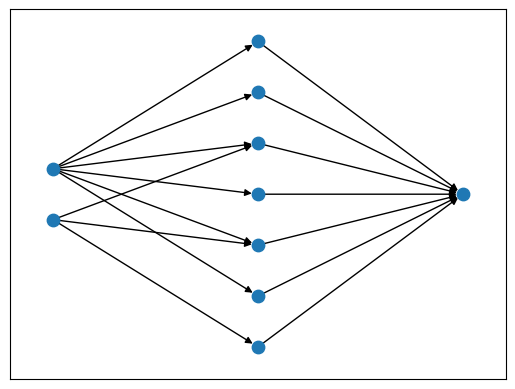

In [23]:

W_stars, listik = model.sparse_weighs(alpha=1e-5, epsilon=0.2)


G_after = nx.DiGraph(listik)


listik = list(set(sum(listik, ())))
for node in listik:
        G_after.nodes[node]["layer"] = node[0]

pos_after = nx.multipartite_layout(G_after, subset_key="layer")
fig, ax = plt.subplots(1, dpi = 100)
nx.draw_networkx(G_after, pos=pos_after, ax=ax, with_labels = False, node_size = 80)
plt.show()

Can also do density plots

----
0.9999999999999941 0.9999999999999941 0.0
0.9999999999999941 0.9999999999997442 1.4351663489056902e-16
0.9999999999997442 0.9999999999864915 6.230465878670224e-15
0.9999999999864915 0.9999997363166779 3.2023737666809953e-13
0.9999997363166779 0.9999406845619043 5.993115733480472e-09
0.9999406845619043 0.9999367165315454 1.3239807819544048e-06
0.9999367165315454 0.9998941359522588 2.6709261661430808e-06
0.9998941359522588 0.9998757814572092 4.866524497526323e-06
0.9998757814572092 0.993760480713234 7.3530248786354835e-06
done, kappa upon which we threshold is  0.993760480713234
node with indices  1 19  is zero,
 ratio for rho is  270 from 270


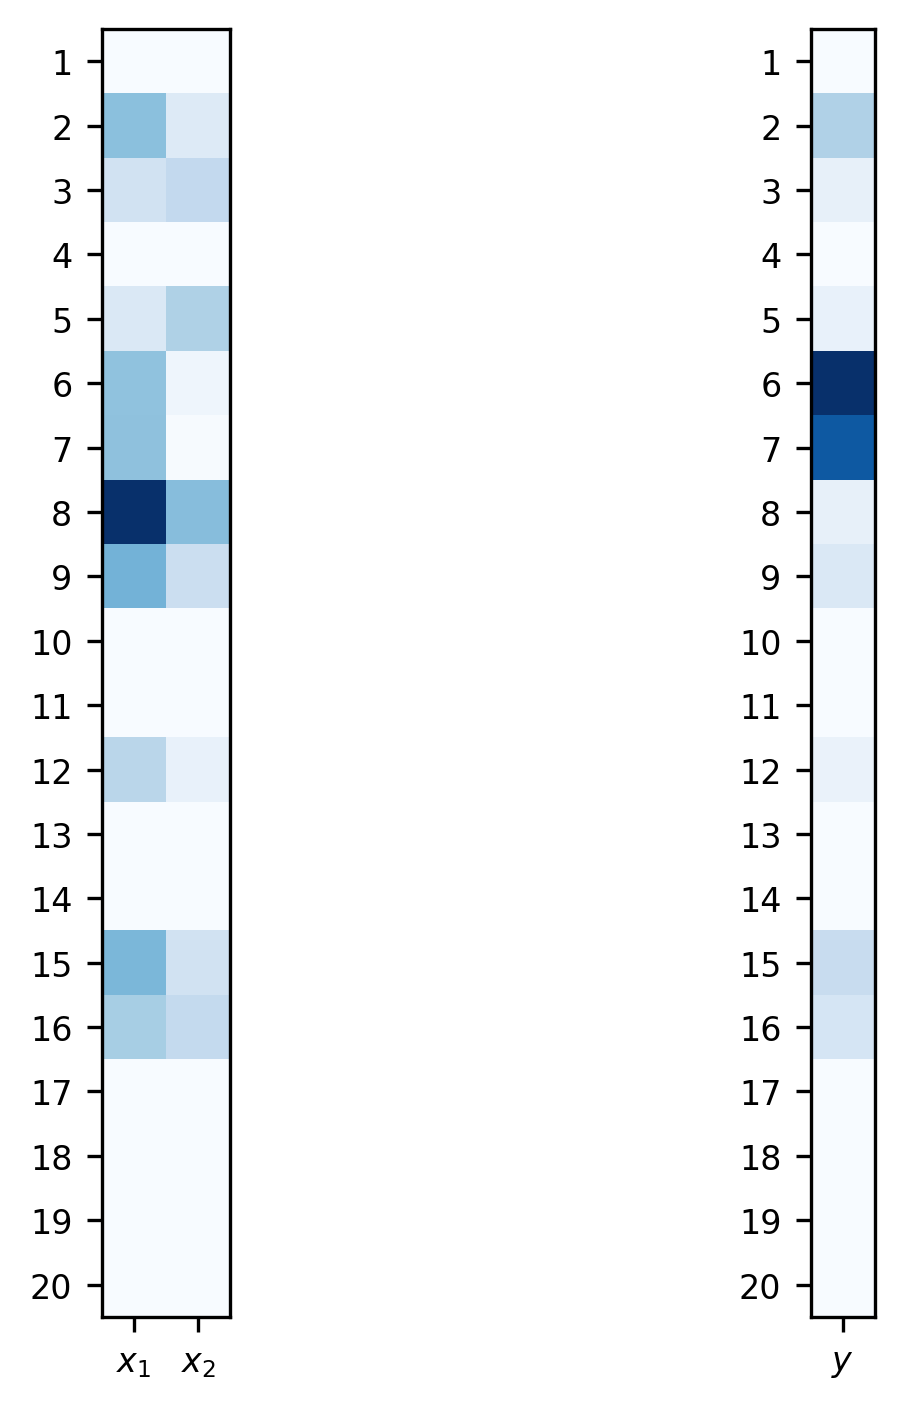

In [ ]:
fig, ax = plt.subplots(1, 2, dpi = 300)

im = ax[0].imshow(np.abs(W_stars[0])/np.max(np.abs(W_stars[0])), cmap = 'Blues', aspect ='equal')
# Add the color bar
# cbar = ax[0].figure.colorbar(im, ax[0] = ax[0])
ax[0].set_xticks(np.arange(0, 2, 1), [r'$x_1$', r'$x_2$'], size = 8)


ax[0].set_yticks(np.arange(0,20), np.arange(1,21), minor = False, size = 8)


im = ax[1].imshow((np.abs(W_stars[1])/np.max(np.abs(W_stars[1]))).T, cmap = 'Blues', aspect ='equal')
# Add the color bar
# cbar = ax[0].figure.colorbar(im, ax[0] = ax[0])
ax[1].set_xticks(np.arange(0, 1, 1), [r'$y$'], size = 8)

ax[1].set_yticks(np.arange(0,20), np.arange(1,21), minor = False, size = 8)

fig.tight_layout()

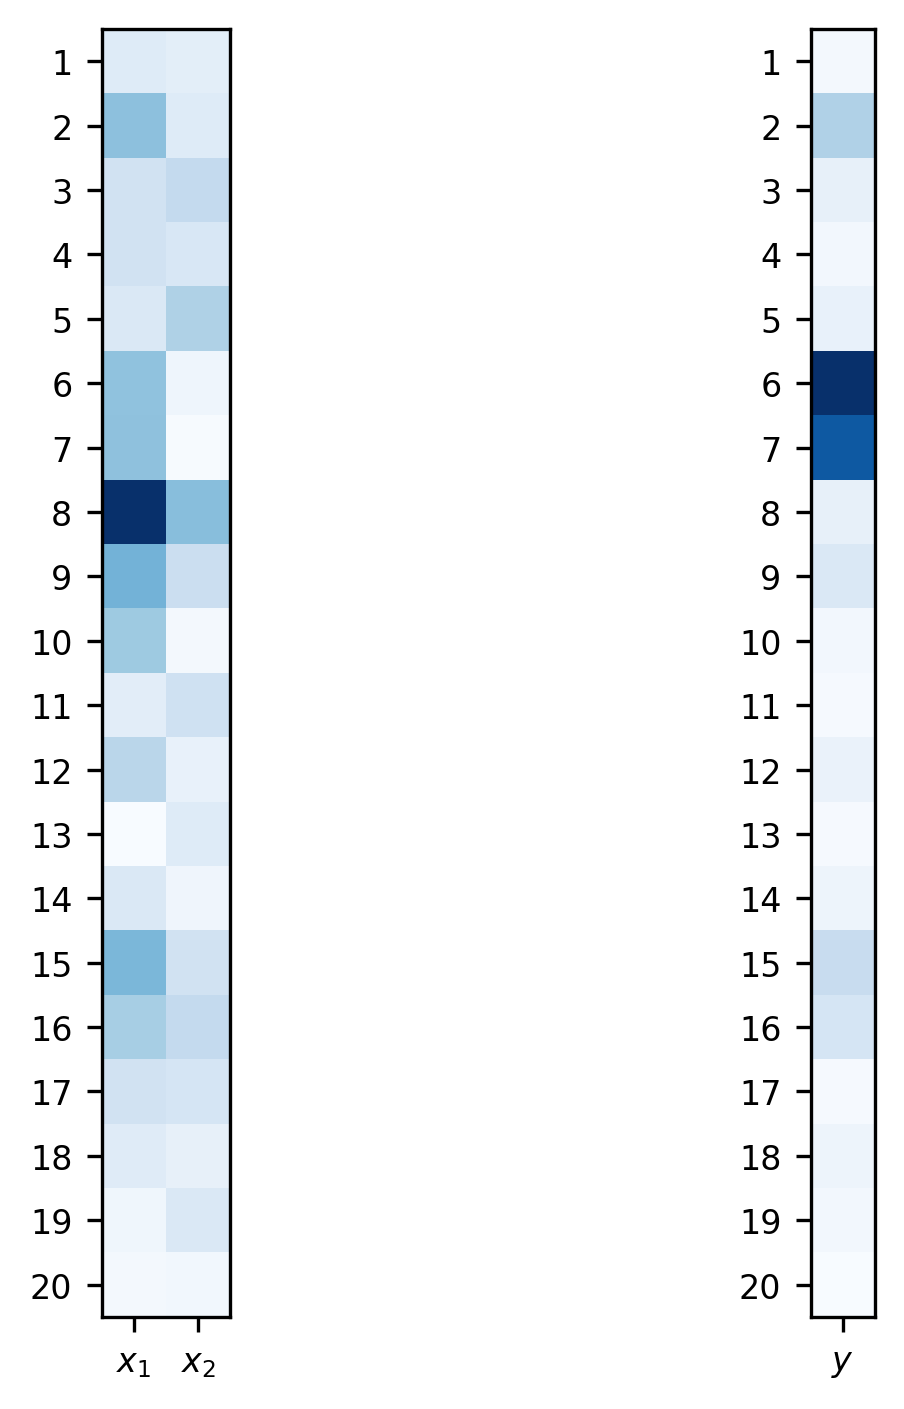

In [21]:


W_stars = []
for k in range(model.L):
   W_stars.append( np.copy(model.m_h[k].squeeze()[:, 1:]))
   

W_stars.append(np.array([model.m_o[i][0,1:].T for i in range(model.D[model.L +1])]))



listik = []
for k in range(model.L+1):
    for j in range(model.D[k]):
        for i in range(model.D[k+1]):
            if W_stars[k][:, j][i] != 0:
                listik.append(((str(k) + str(j)),(str(k+1) + str(i))))


fig, ax = plt.subplots(1, 2, dpi = 300)



im = ax[0].imshow(np.abs(W_stars[0])/np.max(np.abs(W_stars[0])), cmap = 'Blues', aspect ='equal')

ax[0].set_xticks(np.arange(0, 2, 1), [r'$x_1$', r'$x_2$'], size = 8)



ax[0].set_yticks(np.arange(0,20), np.arange(1,21), minor = False, size = 8)


im = ax[1].imshow((np.abs(W_stars[1])/np.max(np.abs(W_stars[1]))).T, cmap = 'Blues', aspect ='equal')
# Add the color bar
# cbar = ax[0].figure.colorbar(im, ax[0] = ax[0])
ax[1].set_xticks(np.arange(0, 1, 1), [r'$y$'], size = 8)

ax[1].set_yticks(np.arange(0,20), np.arange(1,21), minor = False, size = 8)

fig.tight_layout()



### Plotting x_2

Text(0.5, 0, '$x_2$')

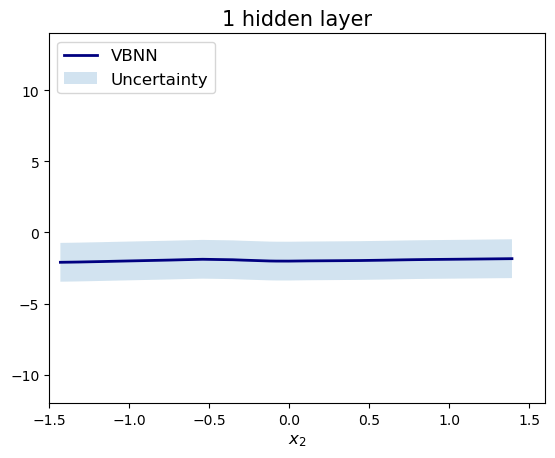

In [ ]:

X_2 = np.copy(X_p)
X_2[:, 0] = np.ones(X_p.shape[0])*X_2[:, 0].mean()


m = ELBO_Choice(parameters_choice)
model = m.model_choice(runs = 1,  epochs=140, rate = 1e-6, dm = True)
model.predict(X_2, 40, 1e-5)
prediction = np.copy(model.prediction_mean)
prediction_std = np.sqrt(model.var_tot)

alpha = 1e-5
y_model_sparse = (model.sparse_predict(x_for_pred=X_2, epochs_pred = 30, alpha =alpha))
var_tot_sparse = (np.copy(model.var_tot))



X_2 = X_2[:, 1]
xidx = (X_2.reshape(-1)).argsort()

plt.plot(X_2.reshape(-1)[xidx], prediction[:, 0].reshape(-1)[xidx], label= 'VBNN', linewidth = 2, color = 'navy')
plt.fill_between(X_2.reshape(-1)[xidx], prediction[:, 0].reshape(-1)[xidx] - 2*prediction_std.reshape(-1)[xidx], prediction[:, 0].reshape(-1)[xidx] + 2* prediction_std.reshape(-1)[xidx], alpha = 0.2, label = 'Uncertainty')


plt.xlim(-1.5, 1.6)
plt.ylim(-12, 14)
plt.title('1 hidden layer', fontsize = 15)
plt.legend(loc = 'upper left', fontsize = 12)
plt.xlabel(r'$x_2$', fontsize = 12)
